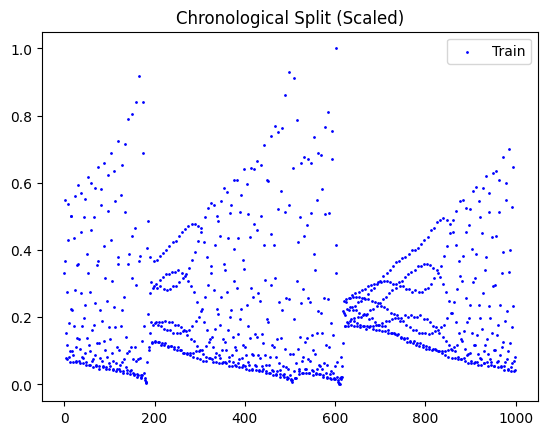

In [25]:
import torch
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

#Load the datafile
data = loadmat('Xtrain.mat')
data = data['Xtrain'].squeeze()
data = data.reshape(-1, 1)

split_ratio = 0.5
train_size = int(len(data) * split_ratio)

train_data = data#[:train_size]
val_data = data[train_size:]

#Scale data between [0,1] use min and max from train data and apply those to val data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)

#Plot the scaled data
#plt.plot(np.arange(len(train_scaled)), train_scaled, label='Train')
plt.scatter(np.arange(len(train_scaled)), train_scaled, s=1, label='Train', color='blue')
#plt.plot(np.arange(len(train_scaled), len(data)), val_scaled, label='Validation')
plt.legend()
plt.title("Chronological Split (Scaled)")
plt.show()

In [8]:
#For the whole lader sequence generate corresponding data points. X is the first input_len of numbers, Y is the one after. 
#Loop over the whole laser sequence
def create_sequences(data, input_len):
    X, Y = [], []
    for i in range(len(data) - input_len):
        X.append(data[i:i + input_len])
        Y.append(data[i + input_len])
    X = torch.tensor(X, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.float32)
    return X, Y


In [9]:
import torch.nn as nn

#Define LSTM model
import torch
import torch.nn as nn

class LSTMOneStep(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.3):
        super(LSTMOneStep, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM stack
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0  # dropout only active if layers > 1
        )

        # Optional deeper head
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)         # lstm_out: [batch, seq_len, hidden]
        out = lstm_out[:, -1, :]           # Take output from last time step
        out = self.head(out)               # Pass through head
        return out


In [47]:
class DeepLSTMOneStep(nn.Module):
    def __init__(self, input_size=1, hidden_size=124, num_layers=3, dropout=0.5):
        super(DeepLSTMOneStep, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )

        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]  # Use the last timestep
        return self.head(last_out)


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

#Hyperparameter configuration
epochs = 20
batch_size = 32
learning_rate = 0.001
hidden_size = 124
num_layers = 3
dropout = 0.5
input_len = 100


#Create data sequences
X_train, Y_train = create_sequences(train_scaled, input_len)
#X_val, Y_val = create_sequences(val_data, input_len)

#Convert train data to DataLoader
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=False)

# val_loader = torch.utils.data.DataLoader(
#     torch.utils.data.TensorDataset(X_val, Y_val), batch_size=batch_size, shuffle=False)

#Initialize model
#model = LSTMOneStep(input_size=1, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
model = DeepLSTMOneStep(input_size=1, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

#Training loop
for epoch in range(epochs):  
    model.train()
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch: {epoch} || train Loss: {loss}")



Epoch: 0 || train Loss: 0.027167176827788353
Epoch: 1 || train Loss: 0.03048601560294628
Epoch: 2 || train Loss: 0.028353102505207062
Epoch: 3 || train Loss: 0.03260926157236099


KeyboardInterrupt: 


Fold 1
Epoch 1: Train Loss = 0.0566
Epoch 2: Train Loss = 0.0414
Epoch 3: Train Loss = 0.0411
Epoch 4: Train Loss = 0.0391
Epoch 5: Train Loss = 0.0398
Epoch 6: Train Loss = 0.0393
Epoch 7: Train Loss = 0.0389
Epoch 8: Train Loss = 0.0395
Epoch 9: Train Loss = 0.0389
Epoch 10: Train Loss = 0.0366
Epoch 11: Train Loss = 0.0365
Epoch 12: Train Loss = 0.0322
Epoch 13: Train Loss = 0.0293
Epoch 14: Train Loss = 0.0217
Epoch 15: Train Loss = 0.0187
Epoch 16: Train Loss = 0.0154
Epoch 17: Train Loss = 0.0156
Epoch 18: Train Loss = 0.0131
Epoch 19: Train Loss = 0.0133
Epoch 20: Train Loss = 0.0138
Epoch 21: Train Loss = 0.0140
Early stopping at epoch 21


c:\Users\brien\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1 - MAE: 0.1609, RMSE: 0.2067


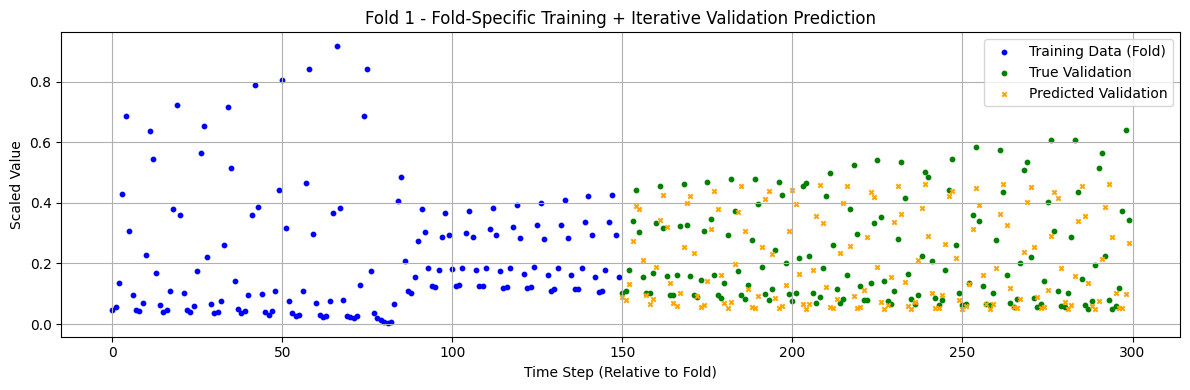


Fold 2
Epoch 1: Train Loss = 0.0410
Epoch 2: Train Loss = 0.0341
Epoch 3: Train Loss = 0.0343
Epoch 4: Train Loss = 0.0341
Epoch 5: Train Loss = 0.0338
Epoch 6: Train Loss = 0.0335
Epoch 7: Train Loss = 0.0223
Epoch 8: Train Loss = 0.0207
Epoch 9: Train Loss = 0.0171
Epoch 10: Train Loss = 0.0172
Epoch 11: Train Loss = 0.0130
Epoch 12: Train Loss = 0.0080
Epoch 13: Train Loss = 0.0073
Epoch 14: Train Loss = 0.0110
Epoch 15: Train Loss = 0.0067
Epoch 16: Train Loss = 0.0058
Epoch 17: Train Loss = 0.0075
Epoch 18: Train Loss = 0.0068
Epoch 19: Train Loss = 0.0067
Early stopping at epoch 19


c:\Users\brien\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2 - MAE: 0.2017, RMSE: 0.2718


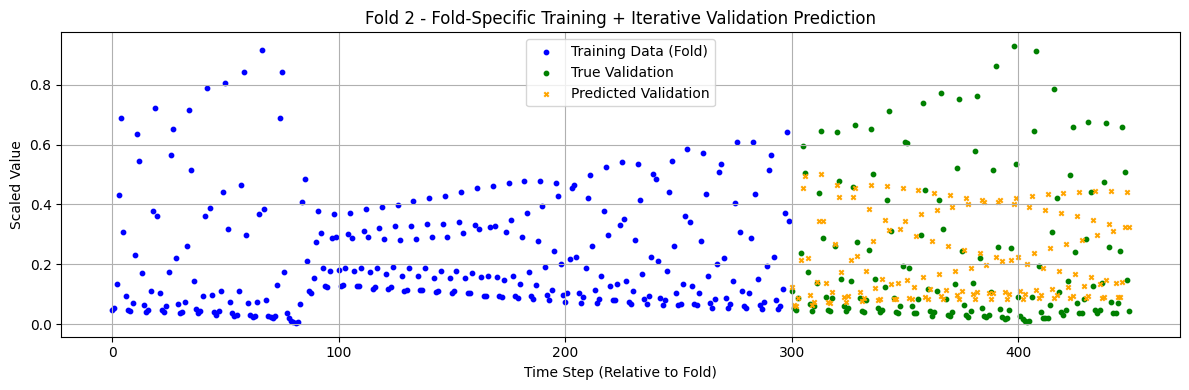


Fold 3
Epoch 1: Train Loss = 0.0573
Epoch 2: Train Loss = 0.0422
Epoch 3: Train Loss = 0.0422
Epoch 4: Train Loss = 0.0407
Epoch 5: Train Loss = 0.0295
Epoch 6: Train Loss = 0.0141
Epoch 7: Train Loss = 0.0165
Epoch 8: Train Loss = 0.0122
Epoch 9: Train Loss = 0.0096
Epoch 10: Train Loss = 0.0082
Epoch 11: Train Loss = 0.0104
Epoch 12: Train Loss = 0.0082
Epoch 13: Train Loss = 0.0084
Epoch 14: Train Loss = 0.0099
Epoch 15: Train Loss = 0.0107
Early stopping at epoch 15


c:\Users\brien\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3 - MAE: 0.1802, RMSE: 0.2496


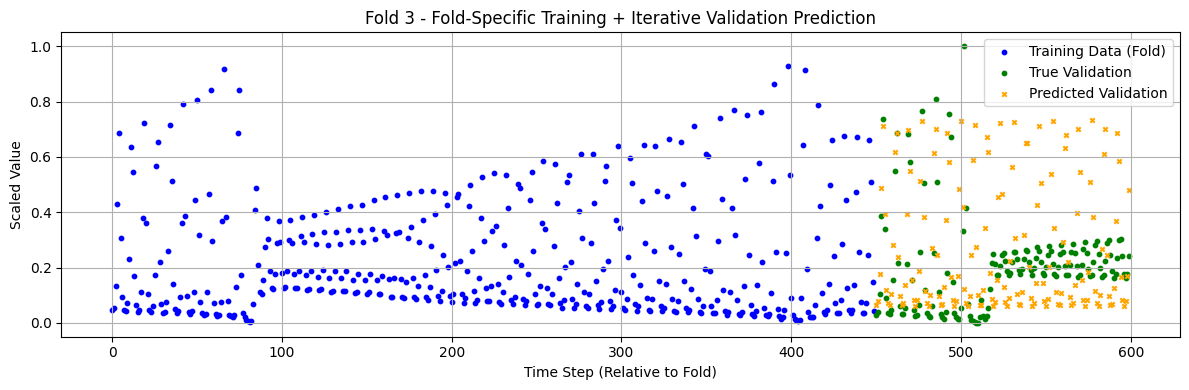


Fold 4
Epoch 1: Train Loss = 0.0432
Epoch 2: Train Loss = 0.0391
Epoch 3: Train Loss = 0.0382
Epoch 4: Train Loss = 0.0210
Epoch 5: Train Loss = 0.0159
Epoch 6: Train Loss = 0.0128
Epoch 7: Train Loss = 0.0113
Epoch 8: Train Loss = 0.0107
Epoch 9: Train Loss = 0.0091
Epoch 10: Train Loss = 0.0088
Epoch 11: Train Loss = 0.0135
Epoch 12: Train Loss = 0.0089
Epoch 13: Train Loss = 0.0079
Epoch 14: Train Loss = 0.0075
Epoch 15: Train Loss = 0.0075
Epoch 16: Train Loss = 0.0077
Epoch 17: Train Loss = 0.0077
Epoch 18: Train Loss = 0.0070
Epoch 19: Train Loss = 0.0071
Epoch 20: Train Loss = 0.0123
Epoch 21: Train Loss = 0.0078
Early stopping at epoch 21


c:\Users\brien\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 4 - MAE: 0.1843, RMSE: 0.2230


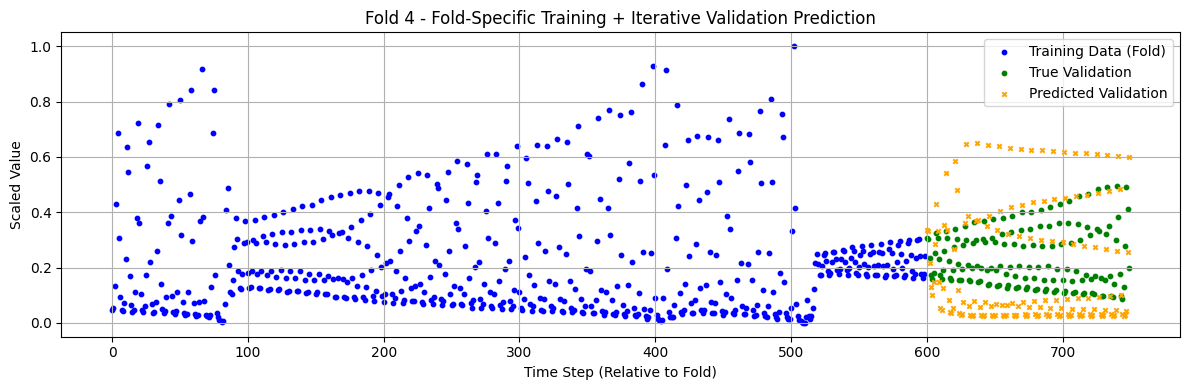


Fold 5
Epoch 1: Train Loss = 0.0441
Epoch 2: Train Loss = 0.0347
Epoch 3: Train Loss = 0.0338
Epoch 4: Train Loss = 0.0299
Epoch 5: Train Loss = 0.0183
Epoch 6: Train Loss = 0.0142
Epoch 7: Train Loss = 0.0111
Epoch 8: Train Loss = 0.0101
Epoch 9: Train Loss = 0.0089
Epoch 10: Train Loss = 0.0072
Epoch 11: Train Loss = 0.0082
Epoch 12: Train Loss = 0.0075
Epoch 13: Train Loss = 0.0066
Epoch 14: Train Loss = 0.0069
Epoch 15: Train Loss = 0.0076
Epoch 16: Train Loss = 0.0056
Epoch 17: Train Loss = 0.0059
Epoch 18: Train Loss = 0.0065
Epoch 19: Train Loss = 0.0058
Early stopping at epoch 19


c:\Users\brien\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 5 - MAE: 0.1862, RMSE: 0.2489


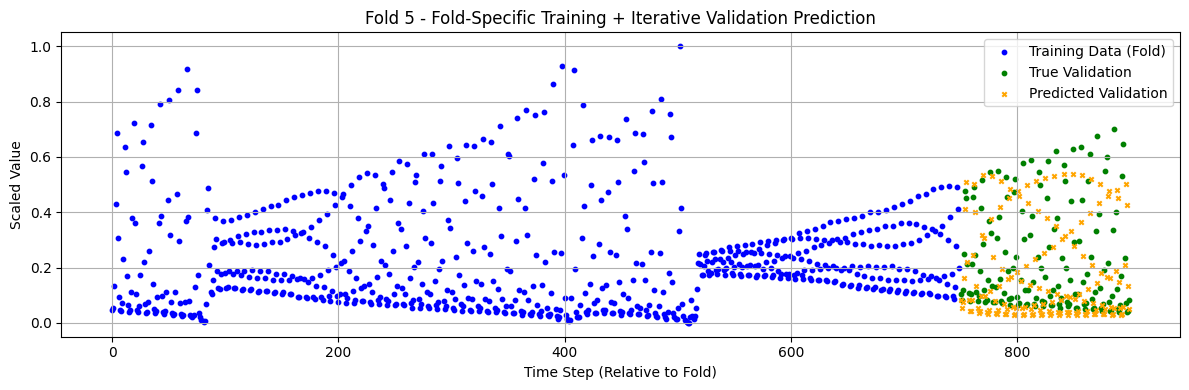

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Hyperparameter configuration
epochs = 50
batch_size = 16
learning_rate = 0.0005
hidden_size = 248
num_layers = 2
dropout = 0.4
input_len = 100
n_splits = 5  # For time series cross-validation
patience = 3  # Early stopping patience

# Create all sequences from the full dataset
X_all, Y_all = create_sequences(train_scaled, input_len)

# Initialize cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)

fold = 1
for train_index, val_index in tscv.split(X_all):
    print(f"\nFold {fold}")

    X_train, X_val = X_all[train_index], X_all[val_index]
    Y_train, Y_val = Y_all[train_index], Y_all[val_index]

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=False)

    # Initialize model for each fold
    #model = LSTMOneStep(input_size=1, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
    model = DeepLSTMOneStep(input_size=1, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    # Training loop with early stopping
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.4f}")

        # Early stopping based on average training loss
        if avg_loss < best_val_loss:
            best_val_loss = avg_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Iterative prediction on validation set
    model.eval()
    input_seq = X_val[0].unsqueeze(0)  # Shape: [1, seq_len, 1]
    preds = []
    with torch.no_grad():
        for _ in range(len(Y_val)):
            pred = model(input_seq)
            preds.append(pred.item())
            new_input = torch.cat([input_seq[:, 1:, :], pred.unsqueeze(0)], dim=1)
            input_seq = new_input

    val_preds = np.array(preds)
    val_targets = Y_val.squeeze().numpy()
    train_targets = Y_train.squeeze().numpy()

    mae = mean_absolute_error(val_targets, val_preds)
    rmse = mean_squared_error(val_targets, val_preds, squared=False)

    print(f"Fold {fold} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    # Visualization of fold-specific train + prediction
    plt.figure(figsize=(12, 4))
    total_points = len(train_targets) + len(val_targets)
    plt.scatter(np.arange(len(train_targets)), train_targets, label='Training Data (Fold)', color='blue', s=10)
    plt.scatter(np.arange(len(train_targets), total_points), val_targets, label='True Validation', color='green', s=10)
    plt.scatter(np.arange(len(train_targets), total_points), val_preds, label='Predicted Validation', color='orange', s=10, marker='x')
    plt.title(f'Fold {fold} - Fold-Specific Training + Iterative Validation Prediction')
    plt.xlabel('Time Step (Relative to Fold)')
    plt.ylabel('Scaled Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    fold += 1

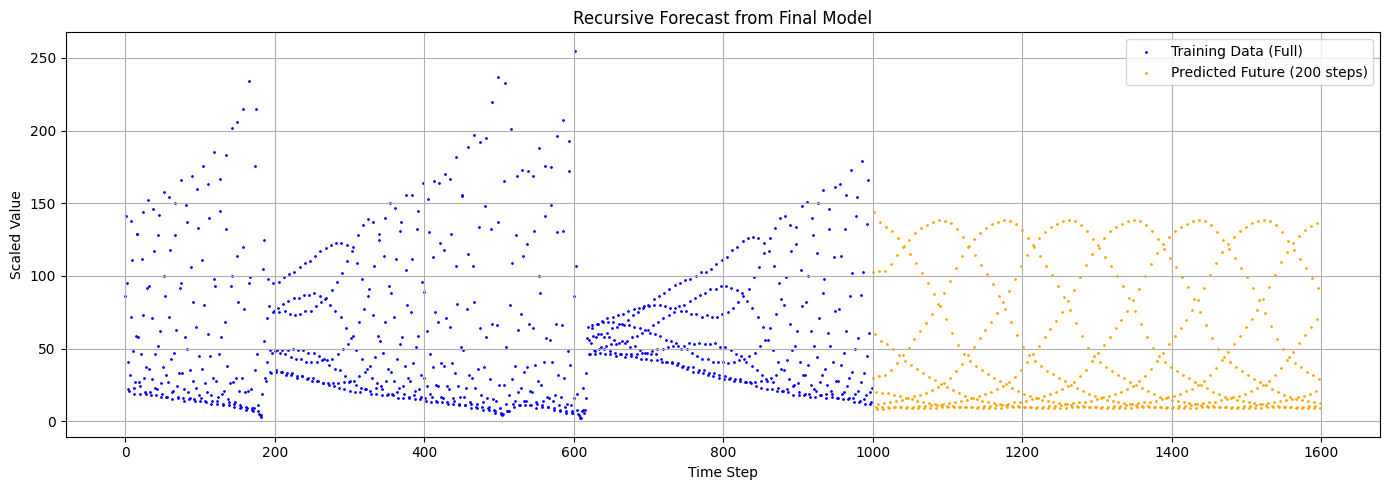

In [64]:
# Final recursive forecast after training (on full data)
model.eval()
prediction_range = 600  # Changed prediction range to 800
predictions_scaled = []

# Start with last input_len values from full train_scaled
last_sequence = torch.tensor(train_scaled[-input_len:], dtype=torch.float32).unsqueeze(0)

# Iterative prediction
with torch.no_grad():
    for _ in range(prediction_range):
        pred = model(last_sequence)
        predictions_scaled.append(pred.item())
        new_val = pred.unsqueeze(2)  # shape: [1, 1, 1]
        last_sequence = torch.cat((last_sequence[:, 1:, :], new_val), dim=1)

# Rescale predictions
predictions_np = np.array(predictions_scaled).reshape(-1, 1)
predictions_unscaled = scaler.inverse_transform(predictions_np).squeeze()

# Plot full training set + 800-step prediction
plt.figure(figsize=(14, 5))
# plt.plot(train_scaled.squeeze(), label="Training Data (Scaled)", color='blue')
# plt.plot(np.arange(len(train_scaled), len(train_scaled) + prediction_range), predictions_scaled, 
#          label="800-Step Forecast (Scaled)", linestyle='--', color='orange')
plt.scatter(np.arange(len(data)), data, label='Training Data (Full)', color='blue', s=1)
plt.scatter(np.arange(len(data), len(data) + len(predictions_unscaled)), predictions_unscaled, 
                label='Predicted Future (200 steps)', color='orange', s=1)
plt.title("Recursive Forecast from Final Model")
plt.xlabel("Time Step")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
